<a href="https://colab.research.google.com/github/jrkirschner2004-ctrl/ML-F2025/blob/main/MLE_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MLE Homework 4
Joseph Kirschner


RIN: 662038912

1.) Construct a fully connected neural network model for classifying the CIFAR-10
dataset. Use a 70%-30% split for training and validation data.


(a) (10 pts.) Visualize the data by plotting an image from each category from the
CIFAR-10 dataset.

In [26]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import numpy as np

# Load the CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train_full = x_train_full / 255.0
x_test = x_test / 255.0

# One-hot encode the labels
y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Split the training data into training and validation sets (70%-30% split)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.3, random_state=42)

print("Training data shape:", x_train.shape)
print("Validation data shape:", x_val.shape)
print("Test data shape:", x_test.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (35000, 32, 32, 3)
Validation data shape: (15000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Training labels shape: (35000, 10)
Validation labels shape: (15000, 10)
Test labels shape: (10000, 10)


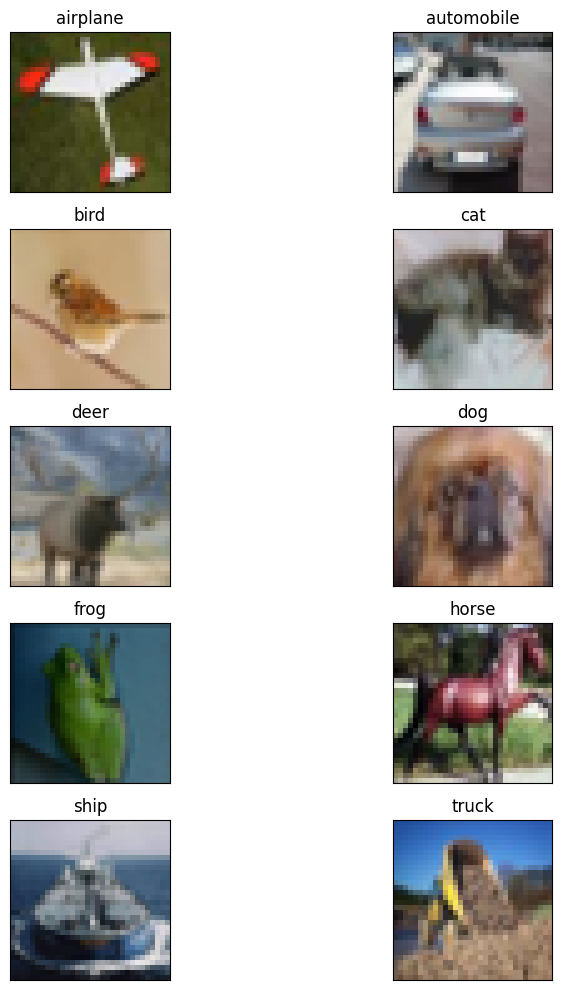

In [27]:
import matplotlib.pyplot as plt

# Define the list of class names for the CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Iterate through each class to find and plot one image
plt.figure(figsize=(10, 10))
for i, class_name in enumerate(class_names):
    # Find the index of the first image belonging to the current class
    class_index = np.argmax(y_train, axis=1) == i
    first_image_index = np.where(class_index)[0][0]

    # Plot the image
    plt.subplot(5, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[first_image_index])
    plt.title(class_name)

plt.tight_layout()
plt.show()

(b) (30 pts.) Demonstrate the tuning of the hyperparameters of the neural network
via grid-search.

In [28]:
param_grid = {
    'learning_rate': [0.001, 0.0005],
    'dropout_rate': [0.0, 0.2]
}

print(param_grid)

{'learning_rate': [0.001, 0.0005], 'dropout_rate': [0.0, 0.2]}


In [29]:
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

results = []
best_accuracy = -1
best_params = {}

param_grid = {
    'learning_rate': [0.001, 0.0005],
    'dropout_rate': [0.0, 0.2]
}

for learning_rate, dropout_rate in itertools.product(param_grid['learning_rate'], param_grid['dropout_rate']):
    print(f"Testing combination: learning_rate={learning_rate}, dropout_rate={dropout_rate}")

    # Build the model
    model = Sequential([
        tf.keras.Input(shape=(32, 32, 3)), # Use tf.keras.Input as the first layer
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Define Early Stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(x_train, y_train,
                        epochs=20,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping],
                        verbose=0) # Set verbose to 0 to reduce output during grid search

    # Evaluate the model on the validation set
    loss, accuracy = model.evaluate(x_val, y_val, verbose=0)

    # Store the results
    results.append({
        'learning_rate': learning_rate,
        'dropout_rate': dropout_rate,
        'validation_accuracy': accuracy,
        'validation_loss': loss
    })

    # Check if this is the best model so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'learning_rate': learning_rate, 'dropout_rate': dropout_rate}

print("\nGrid Search Results:")
for result in results:
    print(result)

print(f"\nBest Hyperparameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy}")

Testing combination: learning_rate=0.001, dropout_rate=0.0
Testing combination: learning_rate=0.001, dropout_rate=0.2
Testing combination: learning_rate=0.0005, dropout_rate=0.0
Testing combination: learning_rate=0.0005, dropout_rate=0.2

Grid Search Results:
{'learning_rate': 0.001, 'dropout_rate': 0.0, 'validation_accuracy': 0.4891333281993866, 'validation_loss': 1.4705123901367188}
{'learning_rate': 0.001, 'dropout_rate': 0.2, 'validation_accuracy': 0.4458666741847992, 'validation_loss': 1.5790724754333496}
{'learning_rate': 0.0005, 'dropout_rate': 0.0, 'validation_accuracy': 0.5045999884605408, 'validation_loss': 1.4234333038330078}
{'learning_rate': 0.0005, 'dropout_rate': 0.2, 'validation_accuracy': 0.4689333438873291, 'validation_loss': 1.5052862167358398}

Best Hyperparameters: {'learning_rate': 0.0005, 'dropout_rate': 0.0}
Best Validation Accuracy: 0.5045999884605408


(c) (5 pts.) Calculate and plot the training and validation losses of the tuned network.

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Retrain the model with the best hyperparameters
best_learning_rate = best_params['learning_rate']
best_dropout_rate = best_params['dropout_rate']

print(f"Training the final model with best hyperparameters: learning_rate={best_learning_rate}, dropout_rate={best_dropout_rate}")

final_model = Sequential([
    tf.keras.Input(shape=(32, 32, 3)), # Use tf.keras.Input as the first layer
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(best_dropout_rate),
    Dense(256, activation='relu'),
    Dropout(best_dropout_rate),
    Dense(10, activation='softmax')
])

final_optimizer = Adam(learning_rate=best_learning_rate)
final_model.compile(optimizer=final_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define Early Stopping callback for the final training
early_stopping_final = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the final model
history = final_model.fit(x_train, y_train,
                          epochs=20,
                          validation_data=(x_val, y_val),
                          callbacks=[early_stopping_final],
                          verbose=1) # Set verbose to 1 to see training progress

Training the final model with best hyperparameters: learning_rate=0.0005, dropout_rate=0.0
Epoch 1/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2733 - loss: 2.0093 - val_accuracy: 0.3677 - val_loss: 1.7598
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3794 - loss: 1.7256 - val_accuracy: 0.4136 - val_loss: 1.6456
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4175 - loss: 1.6241 - val_accuracy: 0.4392 - val_loss: 1.5808
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4511 - loss: 1.5540 - val_accuracy: 0.4432 - val_loss: 1.5611
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4614 - loss: 1.5084 - val_accuracy: 0.4542 - val_loss: 1.5198
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4721 - loss: 1.4698 - val_accuracy: 0.4538 - val_loss: 1.5339
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4905 - loss: 1.4315 - val_accuracy: 0.4533 - val_loss: 1.5299

Accuracy is noticably bad

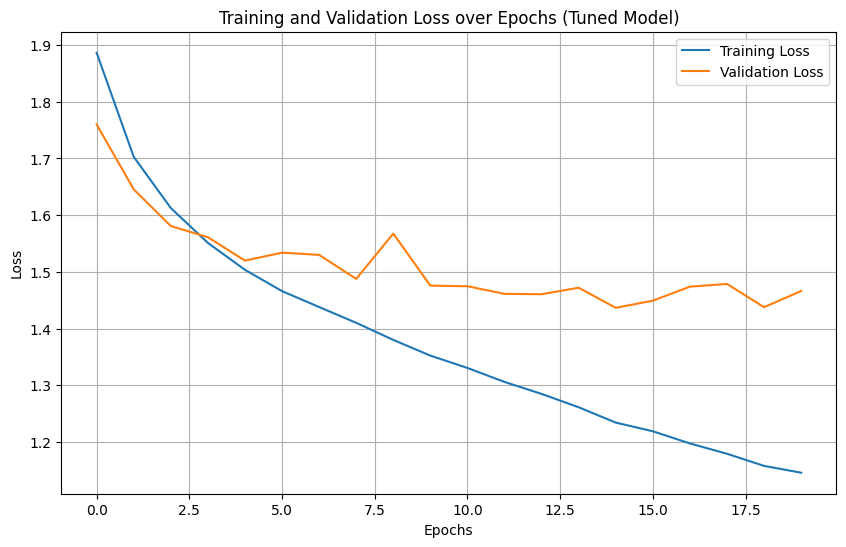

In [31]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs (Tuned Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

(d) (5 pts.) Calculate and plot the training and validation accuracies of the tuned
network.

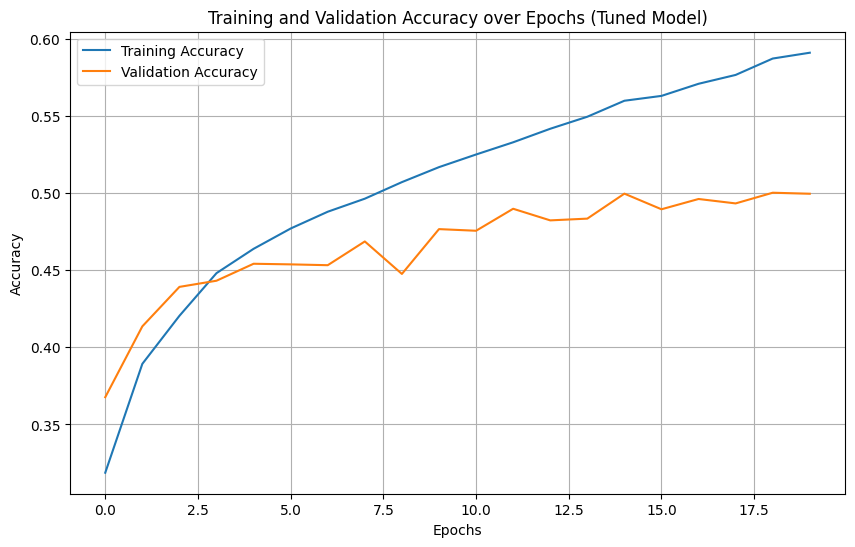

In [32]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs (Tuned Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 2. Obtain the NASA airfoil self-noise dataset from UCI machine learning dataset repository.The dataset describes different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments. The following attributes were measured:
i. Frequency, in Hz.


ii. Angle of attack, in degrees.


iii. Chord length, in meters.


iv. Free-stream velocity, in meters per second.


v. Suction side displacement thickness, in meters.


The only measured output was:


i. Scaled sound pressure level, in decibels.

In [33]:
import pandas as pd

# Define column names based on the dataset description
column_names = [
    'frequency',
    'angle_of_attack',
    'chord_length',
    'free_stream_velocity',
    'suction_side_displacement_thickness',
    'scaled_sound_pressure_level'
]

# Read the .dat file into a pandas DataFrame
# The file is space or tab separated, and has no header
try:
    airfoil_df = pd.read_csv('/content/airfoil_self_noise.dat', sep=r'\s+', header=None, names=column_names)
    print("Dataset loaded successfully.")
    display(airfoil_df.head())
except FileNotFoundError:
    print("Error: airfoil_self_noise.dat not found in /content/. Please ensure the file is uploaded.")
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully.


,frequency,angle_of_attack,chord_length,free_stream_velocity,suction_side_displacement_thickness,scaled_sound_pressure_level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


(a) (10 pts.) Visualize the dataset.

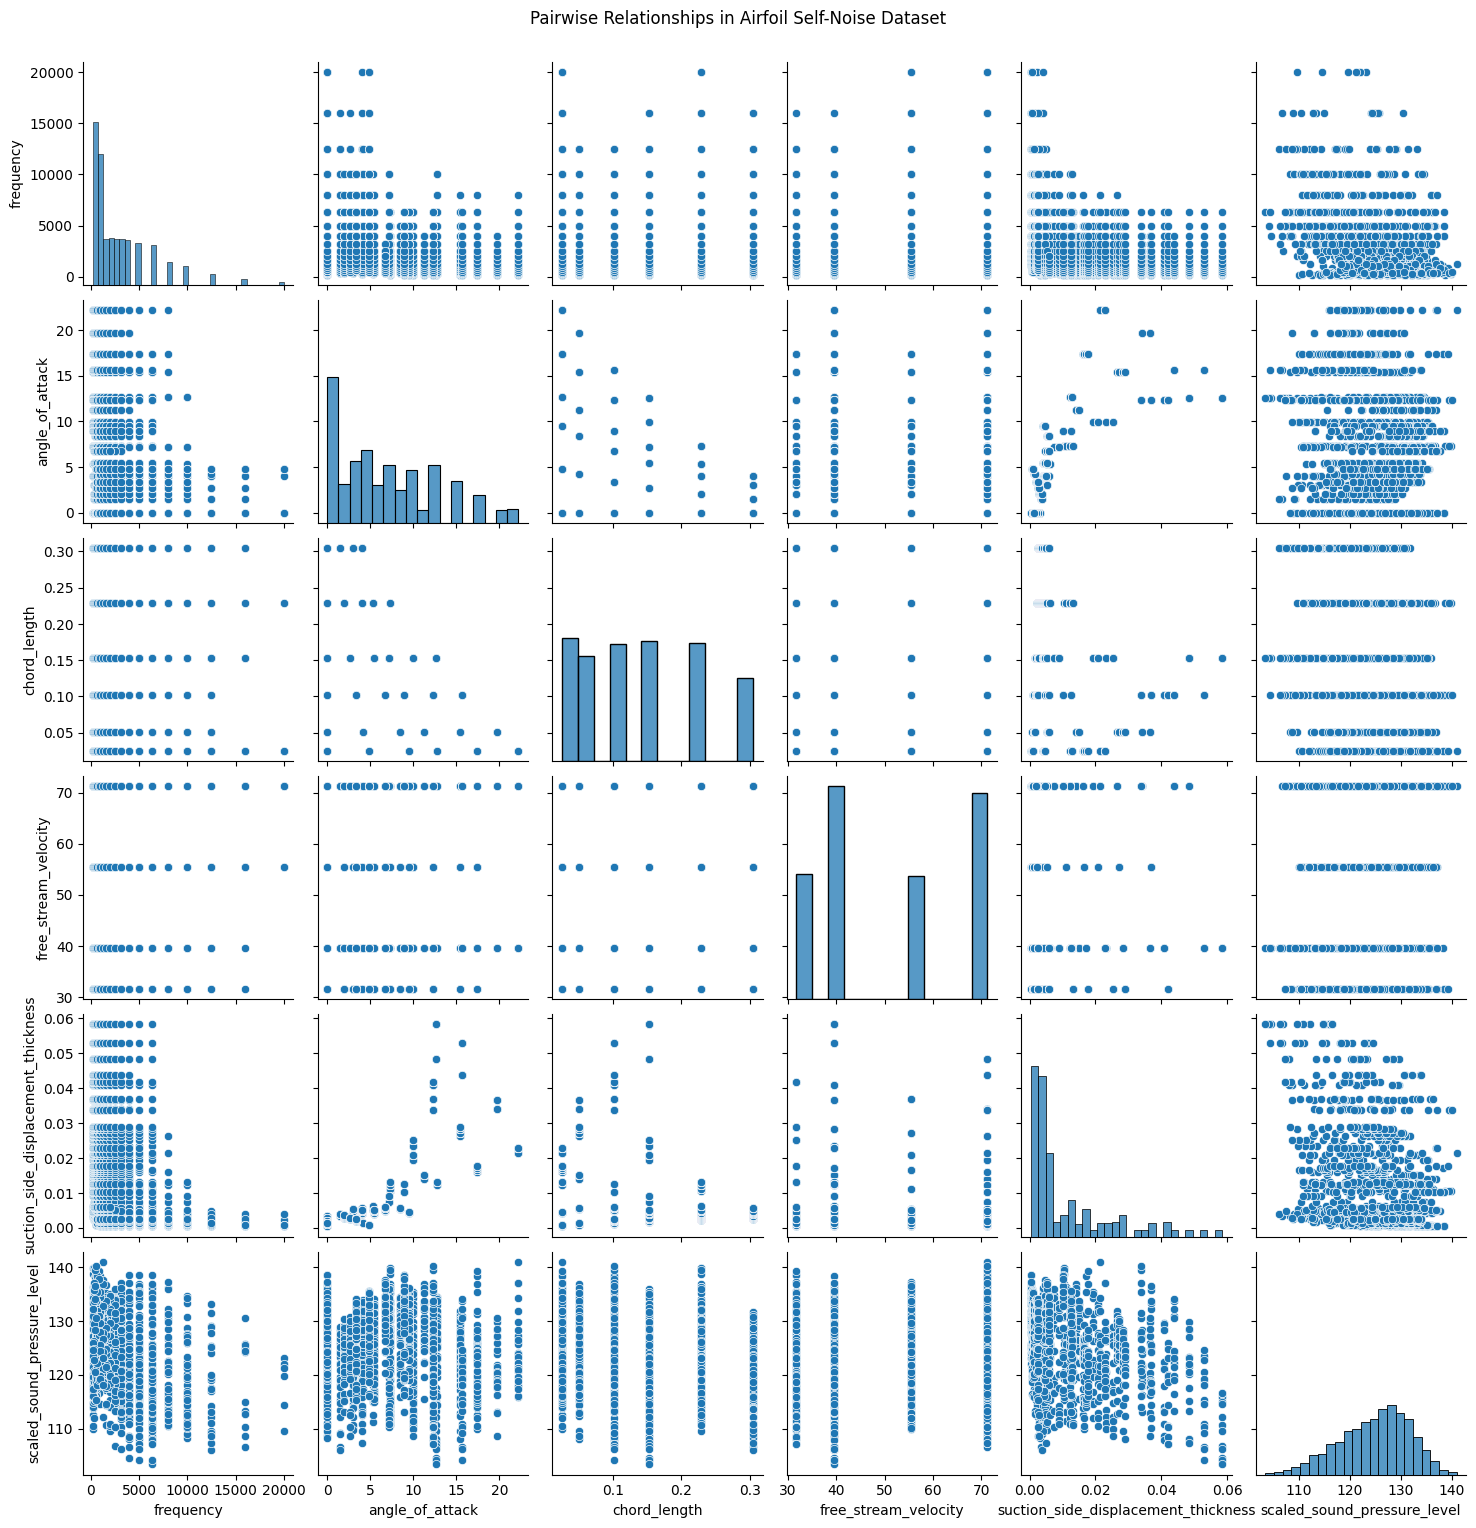

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the dataset using a pairplot
sns.pairplot(airfoil_df)
plt.suptitle('Pairwise Relationships in Airfoil Self-Noise Dataset', y=1.02)
plt.show()

(b) (30 pts.) Construct a fully connected neural network model for estimating scaled sound pressure level, in decibels, from the attributes by choosing a 70%-30% split.

In [35]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD # Import SGD

# Separate features (X) and target variable (y)
X = airfoil_df.drop('scaled_sound_pressure_level', axis=1)
y = airfoil_df['scaled_sound_pressure_level']

# Split data into training and validation sets (70%-30% split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training features shape:", X_train.shape)
print("Validation features shape:", X_val.shape)
print("Training target shape:", y_train.shape)
print("Validation target shape:", y_val.shape)

# Define the neural network model
model = Sequential([
    Dense(64, activation='sigmoid', input_shape=(X_train.shape[1],)),
    Dense(64, activation='sigmoid'),
    Dense(1) # Output layer for regression (predicting a single continuous value)
])

# Compile the model
optimizer = SGD(learning_rate=0.01) # Use SGD with a learning rate
model.compile(optimizer=optimizer,
              loss='mse', # Mean Squared Error is a common loss function for regression
              metrics=['mae']) # Mean Absolute Error is another useful metric for regression

Training features shape: (1052, 5)
Validation features shape: (451, 5)
Training target shape: (1052,)
Validation target shape: (451,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(c) (10 pts.) Calculate the coefficient of determination.

In [36]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and validation data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Training features shape after scaling:", X_train_scaled.shape)
print("Validation features shape after scaling:", X_val_scaled.shape)

Training features shape after scaling: (1052, 5)
Validation features shape after scaling: (451, 5)


In [37]:
# Train the model
history = model.fit(X_train_scaled, y_train, # Use scaled training features
                    epochs=100, # You can adjust the number of epochs
                    validation_data=(X_val_scaled, y_val), # Use scaled validation features
                    verbose=1) # Set verbose to 1 to see training progress

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2489.4644 - mae: 26.9583 - val_loss: 47.4008 - val_mae: 5.7127
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45.5399 - mae: 5.4989 - val_loss: 45.8127 - val_mae: 5.4254
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44.4318 - mae: 5.4234 - val_loss: 34.6193 - val_mae: 4.8178
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.5217 - mae: 4.6132 - val_loss: 48.9738 - val_mae: 5.7183
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.7447 - mae: 4.2099 - val_loss: 23.8950 - val_mae: 3.8186
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.9445 - mae: 3.7525 - val_loss: 22.2484 - val_mae: 3.5969
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.3974 - mae: 3.4942 - val_loss: 21.5210 - val_mae: 3.5093
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.2845 - mae: 3.4648 - val_loss: 21.1264 - val_mae: 3.4760
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

In [39]:
from sklearn.metrics import r2_score

# Make predictions on the scaled validation set
y_pred = model.predict(X_val_scaled) # Use scaled validation features for prediction

# Calculate the coefficient of determination (R-squared)
r2 = r2_score(y_val, y_pred)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [40]:
print(f"Coefficient of Determination (R-squared): {r2}")

Coefficient of Determination (R-squared): 0.725960215958166
